# COVID-19 Impact on Bike Sharing System Using Ford GoBike System Data
## by Han Kim

## Investigation Overview

> Bay Wheels (began with Bay Area Bike Share in Auguest, 2013 and with Ford GoBike in June, 2017 and named Bay Wheels from June, 2019) is a regional public bicycle sharing system in the San Francisco Bay Area, California. It is operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District and owned by Lyft.

> In this project, the data set of March 2020 has been chosen for understanding the impacts of COVID-19 on the bike sharing system in the Bay Area since nearly 40 million Californians including Bay Area residence were required to stay home and limit social interaction until further notice when Gov. Gavin Newsom announced a stay-at-home order on March 19 to reduce the spread of the novel coronavirus. According to [abc7news](https://abc7news.com/shelter-in-place-extended-bay-area-extends-stay-at-home-6-counties/6019152/), the statewide order followed similar action in the San Francisco Bay Area where residents in six counties, and later all nine, were told to shelter-in-place starting `March 17` to slow the spread of the virus. 

## Dataset Overview

> Original dataset contains 176,800 trip records with the following 14 variables.
- duration_sec
- start_time
- end_time
- start_station_id
- start_station_name
- start_station_latitude
- start_station_longitude
- end_station_id
- end_station_name
- end_station_latitude
- end_station_longitude
- bike_id
- user_type
- rental_access_method

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load 2020/03 dataset using pandas module
df = pd.read_csv('202003-baywheels-tripdata.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['user_type'] = df['user_type'].astype('category')
df['rental_access_method'] = df['rental_access_method'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
duration_sec               176799 non-null int64
start_time                 176799 non-null datetime64[ns]
end_time                   176799 non-null datetime64[ns]
start_station_id           110696 non-null float64
start_station_name         111349 non-null object
start_station_latitude     176799 non-null float64
start_station_longitude    176799 non-null float64
end_station_id             111097 non-null float64
end_station_name           111794 non-null object
end_station_latitude       176799 non-null float64
end_station_longitude      176799 non-null float64
bike_id                    176799 non-null int64
user_type                  176799 non-null category
rental_access_method       114269 non-null category
dtypes: category(2), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 16.5+ MB


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Before and after shelter-in-place order on San Francisco Bay Area

> The bike trips before the shelter-in-place order contributed the majority of the bike usage in March 2020 while about 18.8% were consumed by after the SIP order. On the other hand, subscribers contributed 57.3 % of the total bike trips made in March 2020 while 42.7% were consumed by customers. The right map shows how the start stations of the bike trips are distributed in the Bay Area’s map.

In [3]:
# remove an outlier which is not available on latitude and longitude information
df = df[df.start_station_longitude!=0]

# limit only San Francisco Bay Area
df = df.query('end_station_latitude > 37.6 and end_station_latitude < 37.9 and end_station_longitude > -122.6 and end_station_longitude < -122.35 and start_station_latitude > 37.6 and start_station_latitude < 37.9 and start_station_longitude > -122.6 and start_station_longitude < -122.35')

# change data type
df['start_date'] = df.start_time.dt.strftime('%Y-%m-%d')

# add another column indicating before and after shelter-in-place (SIP)
def sip(row):
    if row['start_date'] <'2020-03-15':
        val = 'Before shelter-in-place'
    elif row['start_date'] >'2020-03-17':
        val = 'After shelter-in-place'
    else:
        val = None
    return val
            
df['SIP']=df.apply(sip, axis=1)



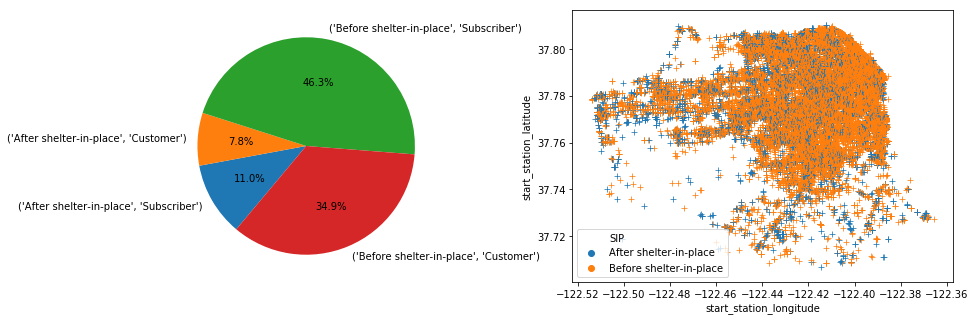

In [4]:

plt.figure(figsize=[15, 5]);
base_color = sb.color_palette()[0]

plt.subplot(1, 2, 1);
sorted_vals = df.groupby('SIP').user_type.value_counts() / df.SIP.count()
plt.pie(sorted_vals, labels=sorted_vals.index, autopct='%1.1f%%', startangle=230, counterclock=False);


plt.subplot(1, 2, 2);
sb.scatterplot(data = df, 
                x = "start_station_longitude",
                y = "start_station_latitude",marker="+", hue = 'SIP');


## Bike usage, average trip duration, average trip distance on day of the week for subscribers and customers for before and after shelter-in-place order 

> Interestingly, the count of the bike users as a subscriber on each day of the week has higher than the count of the customer for both before and after the SIP order, as well as even each hour of the day. Also, in terms of the average trip distance of the bike users, there were the same patterns between subscribers and customers, which is the subscriber for bike trips has longer trips in a distance measurement than the customers. However, the average trip duration of bike trips by subscribers has fewer trips than the ones by customers. 


In [5]:
# add a column of day of the week
df['start_dayofweek'] = df.start_time.dt.strftime('%A')
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# add a column of duration in minutes
df['duration_min'] = df['duration_sec']/60
# add a column of hour of the day
df['start_hourofday'] = df.start_time.dt.strftime('%H')
# add a column of trip distance
import geopy.distance

def cal_distance (lat1,lon1,lat2,lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)

    return geopy.distance.vincenty(coords_1, coords_2).mi

df['trip_distance'] = df.apply(lambda x: cal_distance(x['start_station_latitude'], x['start_station_longitude'], x['end_station_latitude'],x['end_station_longitude']), axis=1)

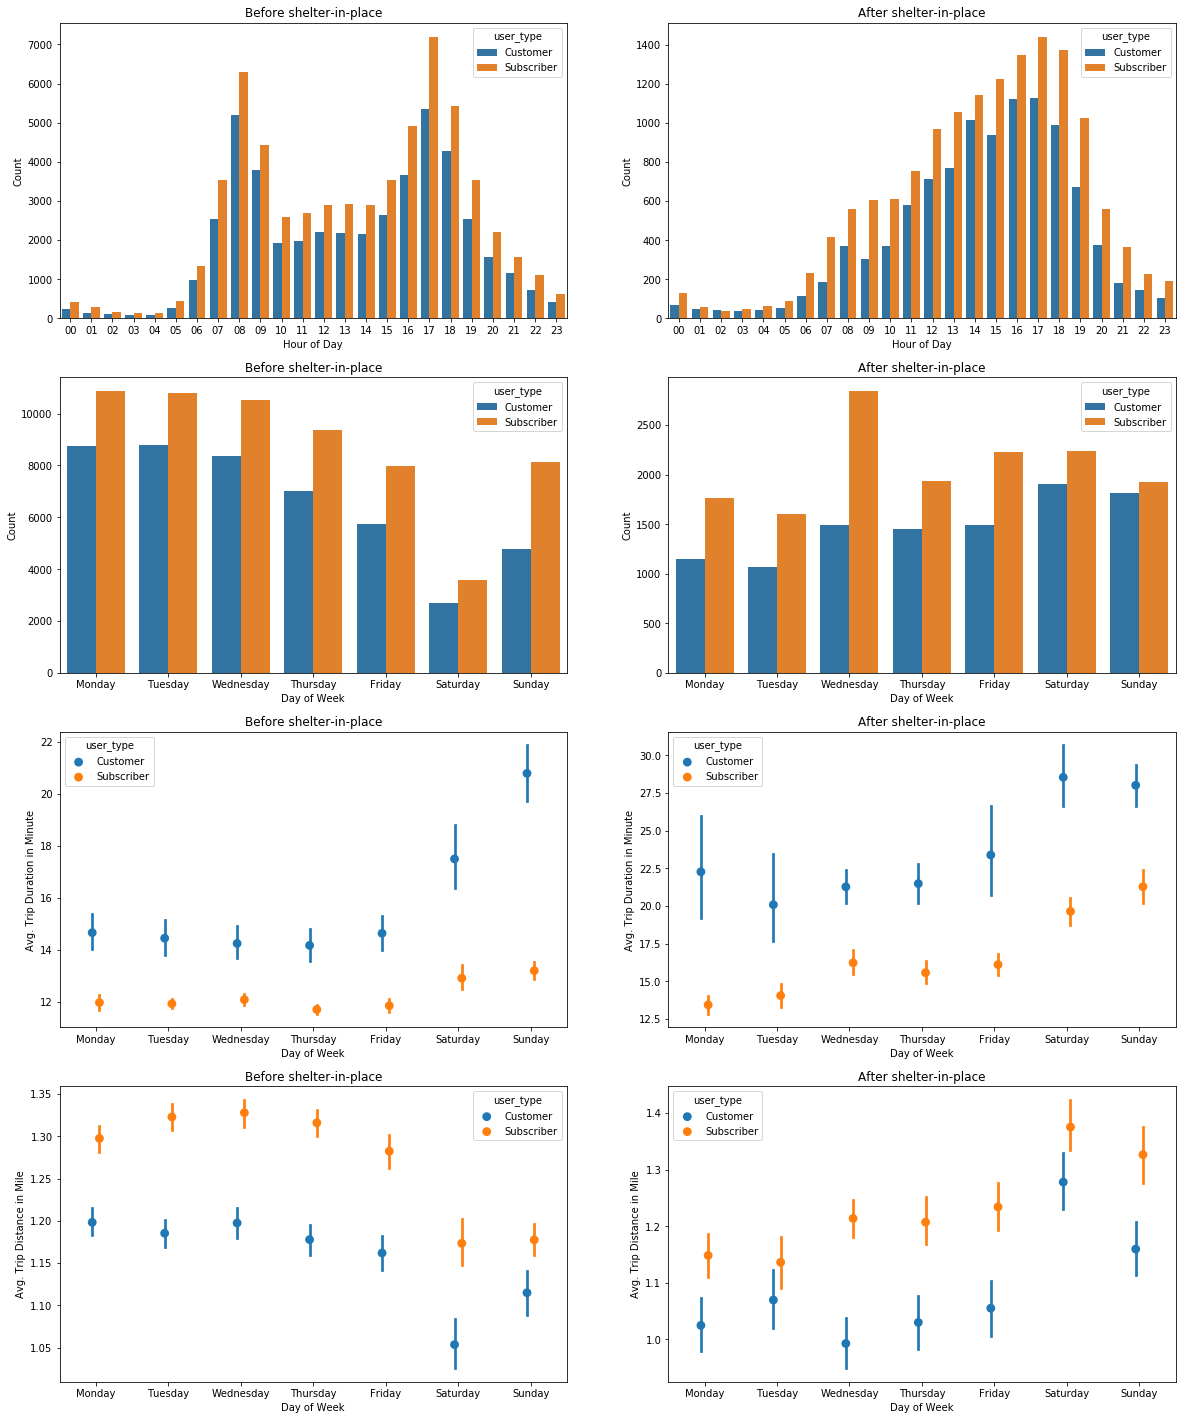

In [6]:
plt.figure(figsize = [20, 25])

plt.subplot(4, 2, 1)
sb.countplot(data=df[df['SIP']=='Before shelter-in-place'], x='start_hourofday', hue='user_type');
plt.xlabel('Hour of Day');
plt.ylabel('Count');
plt.title('Before shelter-in-place');

plt.subplot(4, 2, 2)
sb.countplot(data=df[df['SIP']=='After shelter-in-place'], x='start_hourofday', hue='user_type');
plt.xlabel('Hour of Day');
plt.ylabel('Count');
plt.title('After shelter-in-place');

plt.subplot(4, 2, 3)
sb.countplot(data=df[df['SIP']=='Before shelter-in-place'], x='start_dayofweek', hue='user_type', order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Count');
plt.title('Before shelter-in-place');

plt.subplot(4, 2, 4)
sb.countplot(data=df[df['SIP']=='After shelter-in-place'], x='start_dayofweek', hue='user_type', order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Count');
plt.title('After shelter-in-place');


plt.subplot(4, 2, 5)
sb.pointplot(data=df[df['SIP']=='Before shelter-in-place'], x='start_dayofweek', y='duration_min', hue='user_type', dodge=0.1, linestyles="", order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Avg. Trip Duration in Minute');
plt.title('Before shelter-in-place');

plt.subplot(4, 2, 6)
sb.pointplot(data=df[df['SIP']=='After shelter-in-place'], x='start_dayofweek', y='duration_min', hue='user_type', dodge=0.1, linestyles="", order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Avg. Trip Duration in Minute');
plt.title('After shelter-in-place');

plt.subplot(4, 2, 7)
sb.pointplot(data=df[df['SIP']=='Before shelter-in-place'], x='start_dayofweek', y='trip_distance', hue='user_type', dodge=0.1, linestyles="", order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Avg. Trip Distance in Mile');
plt.title('Before shelter-in-place');

plt.subplot(4, 2, 8)
sb.pointplot(data=df[df['SIP']=='After shelter-in-place'], x='start_dayofweek', y='trip_distance', hue='user_type', dodge=0.1, linestyles="", order=weekday);
plt.xlabel('Day of Week');
plt.ylabel('Avg. Trip Distance in Mile');
plt.title('After shelter-in-place');

## Bike usage on hour of the day and on day of the week for subscribers and customers for before and after shelter-in-place order

> On the heatmap, we can easily compare which areas of the day of the week and hour of the day get the most bike usage before and after the SIP order. During the work hours from 6 am through 9 pm on weekdays before the SIP order, there were some bike users in Bay Area, but the count of bike trips remarkably was reduced after the SIP order. Also, the count of the recreation bike trips on Sundays was reduced after the SIP order.

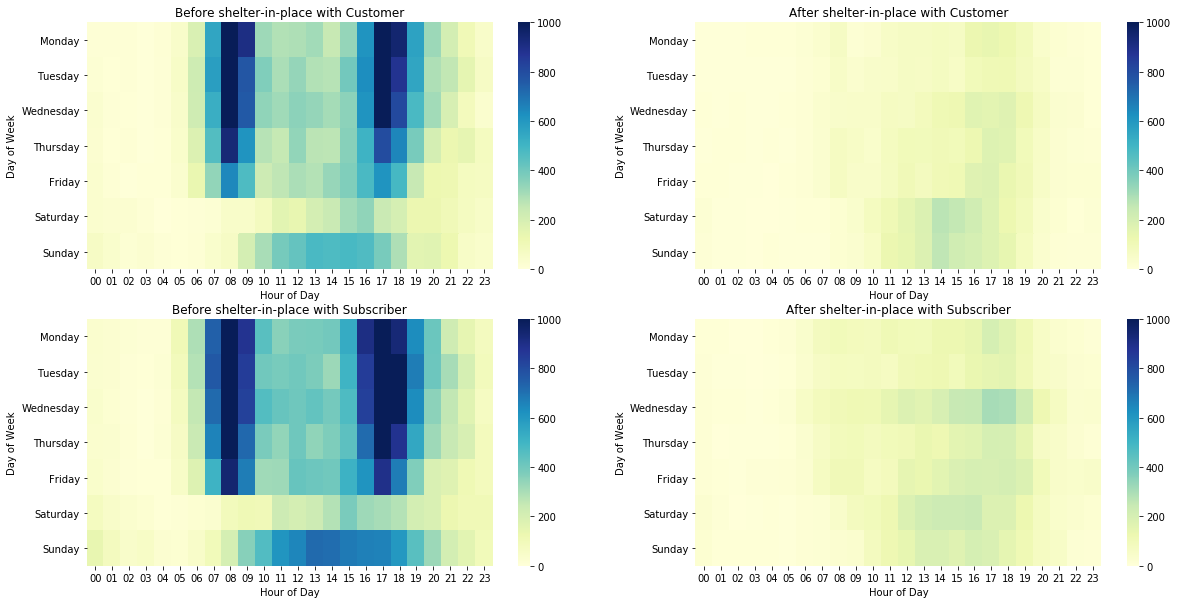

In [7]:
plt.figure(figsize = [20, 10])

plt.subplot(2, 2, 1)
cust = df[df['SIP']=='Before shelter-in-place'].query('user_type == "Customer"')
cust = cust.groupby(['start_dayofweek', 'start_hourofday']).size()
cust = cust.reset_index(name='count')
cust = cust.pivot(index='start_dayofweek', columns='start_hourofday', values='count')
cust.index = pd.CategoricalIndex(cust.index, categories= weekday)
cust.sort_index(level=0, inplace=True)
sb.heatmap(cust, cmap="YlGnBu", vmin=0, vmax=1000);
plt.title('Customer');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');
plt.title('Before shelter-in-place with Customer');

plt.subplot(2, 2, 2)
cust = df[df['SIP']=='After shelter-in-place'].query('user_type == "Customer"')
cust = cust.groupby(['start_dayofweek', 'start_hourofday']).size()
cust = cust.reset_index(name='count')
cust = cust.pivot(index='start_dayofweek', columns='start_hourofday', values='count')
cust.index = pd.CategoricalIndex(cust.index, categories= weekday)
cust.sort_index(level=0, inplace=True)
sb.heatmap(cust, cmap="YlGnBu", vmin=0, vmax=1000);
plt.title('Customer');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');
plt.title('After shelter-in-place with Customer');



plt.subplot(2, 2, 3)
subs = df[df['SIP']=='Before shelter-in-place'].query('user_type == "Subscriber"')
subs = subs.groupby(['start_dayofweek', 'start_hourofday']).size()
subs = subs.reset_index(name='count')
subs = subs.pivot(index='start_dayofweek', columns='start_hourofday', values='count')
subs.index = pd.CategoricalIndex(subs.index, categories= weekday)
subs.sort_index(level=0, inplace=True)
sb.heatmap(subs, cmap="YlGnBu", vmin=0, vmax=1000);
plt.title('Subscriber');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');
plt.title('Before shelter-in-place with Subscriber');


plt.subplot(2, 2, 4)
subs = df[df['SIP']=='After shelter-in-place'].query('user_type == "Subscriber"')
subs = subs.groupby(['start_dayofweek', 'start_hourofday']).size()
subs = subs.reset_index(name='count')
subs = subs.pivot(index='start_dayofweek', columns='start_hourofday', values='count')
subs.index = pd.CategoricalIndex(subs.index, categories= weekday)
subs.sort_index(level=0, inplace=True)
sb.heatmap(subs, cmap="YlGnBu", vmin=0, vmax=1000);
plt.title('Subscriber');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');
plt.title('After shelter-in-place with Subscriber');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [11]:
!jupyter nbconvert slide_deck_fordgobike.ipynb --to slides --post serve --template "output_toggle.tpl.txt"

[NbConvertApp] Converting notebook slide_deck_fordgobike.ipynb to slides
[NbConvertApp] Writing 661182 bytes to slide_deck_fordgobike.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\altai\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\altai\Anaconda3\lib\site-packages\jupyter_core\application.py", line 266, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\altai\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\altai\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 337, in start
    self.convert_notebooks()
  File "C:\Users\altai\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 507, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  